# Machine Learning for Anomaly Detection: Honey Bee Colony Survival Prediction with Isolation Forest and DBSCAN <a class="jp-toc-ignore"></a>
**Table of Contents**
<ol>
<li><a href="#Introduction">Introduction</a></li>
    Dataset and Goal of the Work. Terminology. Notes in Data and Outcomes. 
<li><a href="#Exploratory-Analysis">Exploratory Analysis</a></li>
    Data Cleaning. Data Aggregation. Data Analysis: Colony Loss and Daily Averages. 
<li><a href='#Models'>Models</a></li>
    Model Selection. Detection with Isolation Forest. Detection with DBSCAN.
<li><a href="#Conclusions">Conclusions</a></li>
    Discussion of results and future work.
<li><a href='#References'>References</li>
</ol>

# Introduction

## Dataset and Goal of the Work

This project was an opportunity to combine data science and beekeeping, topics I practice and am passionate about. It was based on  [*MSPB: a longitudinal multi-sensor dataset with phenotypic trait measurements from honey bees*](https://www.nature.com/articles/s41597-024-03695-1) by Zhu et al. The authors have kindly made their data available at https://zenodo.org/records/11398835.

Various beehive monitoring systems have been developed in recent years to address the limitations of human management. Sensors placed inside the hive can record an array of parameters, such as environmental changes (temperature, humidity) as well as acoustic features. This information can be used to train machine learning models that can predict queen and colony status, honey stores, and winter survival. Beekeeping, however, is a millennia-old practice and art. An experienced beekeeper can determine the state of the colony by attentively observing colony behavior and its surroundings, and by carefully inspecting frames. However, such an approach requires time, experience, and patience. In modern beekeeping, time has unfortunately become a luxury, especially for large commercial operations; in these situations, a monitoring system is desirable. 

The dataset consisted of measurements from sensors (Nectar Technologies) located inside 53 Western honey bee (Apis Mellifera) colonies, collected between April 2020 and April 2021, along with evaluations and phenotypic trait measurements performed by apicultural scientists during several inspections in the months of June, July, and August 2020. The colonies were split between two apiaries located in Québec province, Canada.  The sensor data included temperature, relative humidity, and audio features. The phenotypic measurements contained beehive population, number of brood cells, Varroa mite (Varroa destructor) infestation levels, defensive and hygienic behaviors, honey yield, and colony mortality. The audio, temperature, and humidity data were collected at regular intervals of 5 min, 15 min, and 15 min respectively, then transmitted  to a central data aggregator. The relative humidity and temperature information was preserved as recorded. The audio information was sampled at 15.625 kHz; the frequency information (Fourier transform) was processed on-the-fly, and four types of acoustic features were computed: hive power, audio band density ratio, audio density variation, and 16 audio band coefficients (**Table 1**).

The work presented here was based on a subset of the data, consisting of the May and June 2020 recordings. As the goal was to complement the work done by Zhu et al, predict potential colony issues, and determine if long term (winter) survival predictions were possible, this subset was a reasonable choice. From a beekeeper's standpoint, in Northern US and Canada, early summer is extremely important, as that is a time when major nectar flows occur and honey bee colonies build up extensively. By August, in the colder climates of the Northern Hemisphere, a colony's survival dice have been cast. Winter bees, who live much longer than summer bees (several months vs 6 weeks), are typically born in August and September. Thus, good beekeeping practices should identify and address issues well before the month of August.

---
**Table 1: Data dictionary**
___
<table>
<tr><td>$\textbf{Feature}$</td><td>$\textbf{Description}$</td></tr>
<tr><td>published_at, date, time</td><td>Date and time of each observation</td></tr>
<tr><td>tag_number, beehub_name</td><td>colony unique identifier and apiary identifier</td></tr>
<tr><td>geolocation, long, lat</td><td>Geographical coordinates (longitude, latitude) of each colony</td></tr>
<tr><td>Temperature</td><td> Temperature inside the hives (degrees Celsius), recorded every 15 min </td></tr>
<tr><td>Humidity</td><td>Relative humidity (%), recorded every 15 min</td></tr>
<tr><td>Hive power</td><td>Total power (dB) over the band [122 Hz - 519 Hz]</td></tr>
<tr><td>Audio Band Density Ratio</td><td>Ratio of hive power to the total power</td></tr>
<tr><td>Audio Density Variation</td><td>Amount of changes in audio power within 0.98 s</td></tr>
<tr><td>Audio Band Coefficients</td><td>Power (dB) of 16 linearly spaced frequency bands</td></tr>
</table>

## Terminology
* **American foulbrood disease (AFB):** Brood disease of honey bees caused by *Paenibacillus larvae*. The spore stage of the bacterium can remain viable for many years, making it difficult to eliminate the disease. The most effective and widely recommended treatment is the destruction of infected colonies and equipment.
* **Apiary (bee yard):** Collection of colonies, hives, and other equipment assembled in one location for beekeeping operations.
* **Beehive:** Man-made structure in which a honey bee colony lives, typically consisting of several boxes (hive bodies) with movable frames. It is not the sames as **nest**, the term used to describe colonies that house themselves in natural or artificial cavities.
* **Brood:** Immature bees that are still inside their cells. Brood can be in the form of eggs, larvae, or pupae of different ages.
* **Brood chamber (brood box):** The part of the beehive where the brood is reared; may include one or more boxes (hive bodies) and the combs within.
* **Chalkbrood:** Brood disease caused by the fungus Ascosphaera apis; it primarily affects larvae and rarely destroys an entire colony. In many cases, it resolves on its own as temperatures rise in the summer, when the environment is less favorable to the fungus. Preventative measures, such as ensuring good hive ventilation, proper hive placement to maximize sun exposure, and maintaining strong, healthy colonies are considered effective and sustainable approaches. 
* **Colony:** The queen, brood, drones, and worker bees living together in a hive or nest.
* **Drone:** Male honey bee. Drones emerge from unfertilized eggs laid by the queen.
* **Nucleus colony (nuc):** Small colony of bees consisting of fewer frames than a typical hive, usually housed in a smaller box. A nuc usually consists of three to six frames of comb and is used primarily for starting new colonies or rearing or storing queens.
* **Package bees (package):** Quantity of adult bees (2 to 5 pounds), usually with a queen, contained in a screened shipping cage with a food source. A package is a common way to start a new colony.
* **Queen:** Female bee with a fully developed reproductive system. Larger and longer than a worker bee. In normal conditions, the only honey bee that lays eggs. 
* **(Honey) Super:** A box, usually smaller, used for the storage of honey which the beekeeper intends to harvest. Normally it is placed above the brood chamber(s). Supers have the same cross-section as the brood boxes, but are typically lower in height.
* **Supersedure:** The natural replacement of an established mother queen by a newly reared daughter queen in the same hive. Worker bees build supersedure cells and place an egg laid by the existing queen inside each one of them. New queens will emerge in about 16 days which will then fight for dominance. The winning queen will then leave the hive to mate; if she returns successfully, she will restart the egg-laying cycle. Under certain circumstances, it is rare, but possible to find more than one queen living peacefully in a colony.
* **Varroa mite (Varroa destructor):** - Parasitic mite of honey bees. Probably the most serious issue of today's honey bee colonies. It is a disease vector and it weakens bees' immune systems, which can lead to a colony's demise. Unlike the Eastern honey bee (*Apis cerana*), the Western honey bee, (*Apis mellifera*), does not have innate defensive mechanisms against Varroa. 
* **Worker bee:** Female bee whose reproductive organs are undeveloped under normal circumstances. The majority of the honey bees in a colony are worker bees, and they do all the work in the colony except for laying fertile eggs. A very small percent of workers lay unfertilized eggs, which are typically removed by other worker bees. If the queen dies and is not replaced within 10 - 14 days, workers will start laying eggs, but only drones emerge.
* **Phenotype:** Observable, measurable traits/characteristics of an organism that results from the interaction of its genotype with environmental factors.
* **Genotype:** The complete set of genes or genetic material present in an organism. 

## Notes on the Data and Outcomes

Phenotypic and honey store data was only partially collected or not collected at all for colonies that were deemed a summer loss (July-August). Six colonies replaced their queen and in mid-August it was determined one of them did not have a queen, with no details provided regarding how the determination was made. The researchers made the decision to not overwinter these colonies. It is not known whether these colonies actually died. Supersedure is not an uncommon occurrence, especially for colonies started from packages, and it does not mean that the colony will not survive and thrive. 

Correctly labeling outcomes is very important for building a reliable framework for winter survival prediction. As mentioned in the **Introduction**, data can be used to predict a variety of outcomes. However, from an ethical and ecological standpoint, colony survival is the most important. As will be discussed in the next section, it can be argued that not every colony that was considered failed was an objective loss. 

The phenotypic data also contained two measurements of bee defensive behavior, but the two measurements were not reproducible for most colonies and were not included in the project.  Environmental factors, such as surrounding noise, weather, water availability, nectar availability, animals, and beekeeper inspections, influence a colony's demeanor on a given day. However, true defensive behavior is the product of the colony's genetic makeup, so measurements should be reproducible. To ensure reproducibility, defensive behavior in honey bees is typically measured using standardized behavioral assays and controlled testing conditions.

# Exploratory Analysis

## Data Cleaning

Information from three data files was combined for this analysis: a sensor data file and two Excel files containing phenotypic measurements and mortality data.

The dataset containing sensor recordings from April 2020 to Nov 2020 had 960,809 observations (rows) and 30 features (columns). This dataset did not contain data labels (outcomes). It contained 122351 duplicated observations. There were no missing entries.

The following operations were performed on the data:
1. Duplicated rows were removed.
2. The columns that either had duplicated information or were not used in the analysis were removed.
- *published_at* was the same as *date* and *time*; removed *published_at* and *time* (data was later aggregated per day)
- *geolocation* was the same as (*long, lat*). None of this information was later used in modeling, so it was removed. 
3. String *date* was converted to a `datetime` format and the month and day were extracted as new features.
4. Quality checks were performed and identified issues resolved.
  There were 85 distinct colony identifiers in the sensor data, instead of the 53 specified in the article by Zhu et al. No information could be found about these identifiers. The respective rows were removed from the data. Also, some colonies, such as colony with *tag_number* 20213, appeared at both apiary locations, but should have been at *nectar-bh131* (Dubuc apiary). Nothing in the information provided by the study authors indicated that colonies were moved between the two locations, so this was assumed to be a recording error (one incorrect digit), and remedied. 
7. Numerical features were analyzed (distributions, descriptive statistics).

In [1]:
import sys
sys.path.append('/home/guardbee/mywork/MyProjects/libs')

# Import libraries and custom functions
from libraries_functions import *
pd.set_option('display.max_columns', None) # display all columns

# Import sensor data
df = pd.read_csv('D1_sensor_data.csv')
df_copy = df.copy()
# print(df.info())
# df.head()

---
**Table 2: Colony identifiers**

---

In [2]:
# Import colony identification information. Per the instructions from the study authors, 
# '2' must be added to the sensor tag to produce the colony identifier.
colony_info_D1 = pd.read_excel('D1_ant.xlsx', sheet_name='ID lookup table', dtype = str)
colony_info_D1['Colony number Nectar'] = ('2' + colony_info_D1['Colony number Nectar']).astype(int) 
colony_info_D1.drop('Colony number CRSAD', axis = 1).head()

,Bee Hub,Yard,Colony number Nectar
0,#BH131,Dubuc,202056
1,#BH121,Côté,202131
2,#BH121,Côté,202040
3,#BH131,Dubuc,202048
4,#BH131,Dubuc,202064


In [3]:
# Read in phenotypic data
phenotypic = pd.read_excel('phenotypic_data.xlsx', sheet_name=0)

# Remove duplicates
dupl = check_duplicates(df, verbose = 0)
#print('Remove ',dupl,'duplicated observations ...')
df = df.drop_duplicates(keep = 'first')

# Verify geolocation is the same as (long, lat):
# df.geolocation = df.geolocation.apply(wkt.loads)
# sum(df.geolocation.map(lambda x: x.x) != df.long), sum(df.geolocation.map(lambda x: x.y) != df.lat) --> (0,0)

# Remove columns
cols_to_drop = ['published_at','time','lat','long','geolocation']
#print('Removing columns', cols_to_drop,'...')

df = df.drop(cols_to_drop, axis = 1)

df.date = df.date.map(lambda x: pd.to_datetime(x, format = '%Y-%m-%d'))
df['month'] = df.date.map(lambda x: x.month)
df['day'] = df.date.map(lambda x: x.day)

# Remove unaccounted colonies
colony_id = colony_info_D1['Colony number Nectar']
difference = list(set(df.tag_number.unique().tolist()) - set(colony_id))
#print('Unique tag numbers:',df.tag_number.unique().size)
#print('Colonies with unaccounted identifiers:',len(difference))
#print('Subset the sensor data to contain only the 53 colony identifiers ...')
df = df[df.tag_number.isin(colony_id)]

Some colonies appeared at both locations (as shown below for colony 202123), most likely a recording error, which was remedied.

In [4]:
(df.iloc[(df.index == 297442) | (df.index == 954222),:8])

,temperature,humidity,tag_number,beehub_name,hive_power,date,hz_122.0703125,hz_152.587890625
297442,38.90,42.15,202123,nectar-bh131,14.983,2020-05-26,35.87,32.91
954222,1.97,74.09,202123,nectar-bh121,-8.632,2020-11-04,3.40,-2.62


In [5]:
result = df.groupby('beehub_name')['tag_number'].unique()
hives_at_both_locations = list(set(result[0]).intersection(set(result[1])))
df.loc[df.tag_number.isin(hives_at_both_locations),'beehub_name'] = 'nectar-bh131'
#df.groupby('beehub_name')['tag_number'].unique().map(lambda x: len(x)).reset_index()

## Data Agreggation

Colony identification, phenotypic measurements, and mortality information were combined with the sensor data.  The following features were added/engineered:
* *loss*:
    - 0, if the colony was alive at the end of the study
    - 1, if it was deemed a loss by the study authors
* *loss_adjusted*:
    - 0, if the colony neither experienced queen issues nor starved
    - 1, if the colony had queen issues, but a queen was present
    - 2, otherwise
* *supersedure*:
    - 0, if supersedure cells were not observed
    - 1, during a 15-day window centered on the date supersedure cells were observed
* *varroa_severity*:
    - 0, if there were no Varroa mites detected in the May measurements (ideal situation)
    - 1, if between 0 and 1 mites per 100 bees were detected
    - 2, if more than 2 mites per 100 bees were detected (a fairly serious issue when it occurs in May)

Feature *loss_adjusted* was a redefinition of colony failure/loss. It excluded the colony with chalkbrood and the colonies with replaced queens from the *loss* group. Severity ranked from 0 (lowest) to 2 (highest).

In the study, supersedure cells were only observed on specific days hives were opened for inspection. However, supersedure is a longer process, as a queen bee takes about 16 days from egg to emergence; therefore  supersedure takes about 2 weeks, which was the reason behind setting feature *supersedure* to 1 for 15 days.

Inspection data (brood frames and honey frames) were sparse, and combining this information with the sensor data would have resulted in excessive missing entries (values). Given that neither of the two models chosen for this project (Isolation Forest and DBSCAN) handles missing values directly, the brood and honey information was not used due to the high level of sparsity. However, as will be discussed in the final section, there are ways to incorporate it, which would provide additional insight into colony strength.

An aggregated dataset was created by taking daily summary statistics (mean, median, standard deviation, skew and kurtosis) for all features except for *supersedure*, a rare event occurring in only 6 of the 53 colonies. 
 
Only the May measurements for *Varroa destructor* load (as number of Varroa per 100 bees) were used to create engineered feature *varroa_severity*, as the goal was to use data up to July 1 to make predictions.

As discussed in the **Introduction**, the defensive measurements were considered subjective and were not used. Hygienic measurements were taken in July and August. However, hygienic behavior in honey bees is primarily dictated by bee genetics: it is a heritable trait of individual workers that confers colony-level resistance against various brood diseases. Thus, an average of the two measurements was included in the final dataset.

Finally, the aggregated summary statistics and the phenotypic  (**Table 3**) were combined in one dataset.

In [6]:
# Read in the data table containing colony identification and survival information.
colony_info = pd.read_csv('colony_survival_info.csv')

## Aggregate data with daily summary statistics
cols1 = ['month', 'day']#, 'supersedure']#,'geolocation'] #lat, long
cols2 = ['temperature','humidity','hive_power'] + list(df.columns[6:-2])

df1 = df.groupby(['date', 'tag_number'])['beehub_name'].unique().reset_index()
df1.beehub_name = df1.beehub_name.map(lambda x: ''.join(x))

for item in cols1:
    df2 = df.groupby(['date', 'tag_number'])[item].max().reset_index()
    df1 = df1.merge(df2)

for item in cols2:    
    df2 = df.groupby(['date', 'tag_number'])[item].mean().reset_index()
    df2 = df2.rename(columns ={item: item+'_mean'})
    df1 = df1.merge(df2)

    df2 = df.groupby(['date', 'tag_number'])[item].median().reset_index()
    df2 = df2.rename(columns ={item: item+'_med'})
    df1 = df1.merge(df2)
    
    df2 = df.groupby(['date', 'tag_number'])[item].std().reset_index()
    df2 = df2.rename(columns ={item: item+'_std'})
    df1 = df1.merge(df2)

    df2 = df.groupby(['date', 'tag_number'])[item].skew().reset_index()
    df2 = df2.rename(columns ={item: item+'_skew'})
    df1 = df1.merge(df2)

    df2 = df.groupby(['date','tag_number'])[item].apply(pd.Series.kurtosis).reset_index()
    df2 = df2.rename(columns={item: item+'_kurt'})
    df1 = df1.merge(df2)

# Note NaNs returned when there is only one entry per day for stddev, skew, kurt. Replace these with 0. 
cols = select_cols(df1,'_std')
cols = list(cols.columns)
df1[cols] = df1[cols].fillna(0)

cols = select_cols(df1,'_skew')
cols = list(cols.columns)
df1[cols] = df1[cols].fillna(0)

cols = select_cols(df1,'_kurt')
cols = list(cols.columns)
df1[cols] = df1[cols].fillna(0)

## Add elapsed time
df1.date =  df1.date.map(lambda x: pd.to_datetime(x, format = '%Y-%m-%d'))

day_1 = df1.groupby('tag_number')['date'].min().reset_index().rename(columns = {'date':'day_1'})
day_1.day_1 = day_1.day_1.map(lambda x: pd.to_datetime(x, format = '%Y-%m-%d'))
df1 = day_1.merge(df1, how = 'outer')

df1['elapsed_days'] = (df1.date - df1.day_1).dt.total_seconds()/(3600*24)

cols = ['elapsed_days']+list(df1.columns[:-1])
df1 = df1[cols]
df1 = df1.drop(['day_1'], axis = 1)

df_agg = df1.merge(colony_info[['tag_number','supersedure_cells']],
                   left_on=['tag_number'], right_on=['tag_number'], how = 'left')

# Add supersedure information
df_agg.supersedure_cells = df_agg.supersedure_cells.map(lambda x: pd.to_datetime(x, format = '%Y-%m-%d'))

df_agg['supersedure'] = 0
for n in np.arange(df_agg.shape[0]):
    if ((df_agg.at[n,'date'] >= (df_agg.at[n,'supersedure_cells'] - timedelta(days = 7))) & 
        (df_agg.at[n,'date'] <= (df_agg.at[n,'supersedure_cells'] + timedelta(days = 7)))):
        df_agg.at[n,'supersedure'] = 1

df_agg = df_agg.drop(['supersedure_cells'], axis = 1)

#df_agg

---
**Table 3: First few rows of the phenotypic data table.**

---

In [7]:
# Prepare phenotypic data
phenotypic['hygienic_overall'] = (phenotypic['cleaning_capacity_pct_jul'] + phenotypic['cleaning_capacity_pct_aug'])/2

phenotypic.loc[phenotypic['varroa_100_bees_may'] > 0, 'varroa_severity'] = 1
phenotypic.loc[phenotypic['varroa_100_bees_may'] > 1, 'varroa_severity'] = 2
#phenotypic.loc[phenotypic['varroa_100_bees_may'] > 2, 'varroa_severity'] = 3
phenotypic = phenotypic.rename(columns = {'varroa_100_bees_may':'varroa_load'})
phenotypic = phenotypic.drop(['varroa_100_bees_aug','cleaning_capacity_pct_jul','cleaning_capacity_pct_aug'], axis = 1)
phenotypic = phenotypic.fillna(0)
phenotypic.head()

,tag_number,varroa_load,hygienic_overall,varroa_severity
0,202056,0.0,84.45,0.0
1,202131,0.0,93.50,0.0
2,202040,0.0,96.50,0.0
3,202048,0.0,97.75,0.0
4,202064,0.0,89.65,0.0


## Data Analysis

### Colony Loss

According to Zhu et al, 18 colonies were determined to be losses (34% loss). Of these, 8 were considered dead before Nov 14, 2020, when the colonies were moved inside a climate-controlled building for the winter. As discussed in the **Data Aggregation** section, an adjusted loss variable was introduced, to reflect the knowledge that the determination of queenlessness (absence of a viable queen) is nuanced, and requires more than one inspection. As shown in **Table 3**, variable *loss_adjusted* reflected the following considerations:
* One colony (202047) was found with chalkbrood in June.
    - Chalkbrood resolves by itself in most cases, as noted in the **Introduction.** Labeling this colony a loss and destroying it was neither reasonable nor standard practice. Burning a bee colony because of chalkbrood is a brutal and extreme measure. Research has shown that social insects display considerable learning ability and complex social behavior, and there is growing evidence bees and other social insects may experience pain. Colony destruction is typically reserved for American Foulbrood disease, which is highly contagious, and only when other measures have been exhausted. There are more humane methods available for this purpose.
    - As Figure 1 illustrates, its average humidity (a, b) was lower than the median humidity, but its temperature was an outlier (c). A combination of cold and humid conditions can produce chalkbrood in honey bee colonies. However, Figure 1a indicates that there were elevated humidity conditions in this hive in late May that would have warranted some intervention, such as relocating the colony to a warmer location. Furthermore, this situation is a very good illustration of how real-time monitoring can prevent a colony loss.
* Several colonies were found with supersedure cells and later with new queens (202054, 202213, 202209, 202210). However, colonies with superseded queens can overwinter successfully. Brood size in these colonies was similar to the other colonies, but their honey stores (where data available) tended to be less than the average stores in the study. Removing these colonies from the study, without actually knowing if they would overwinter or not, had the potential to introduce bias. These colonies should have been kept in the study.

---
**Table 4: Colony losses from April through November.** The information in column *mortality_cause* was taken from the Zhu et al's study notes. Column *loss_date* contained the date of the last recording from a particular colony.

---

In [8]:
#colony_info.loss.value_counts().reset_index()
losses = colony_info[colony_info.loss > 0][['bee_hub','yard','tag_number', 'mortality_cause','supersedure_cells',\
                                    'loss_date','loss' ,'loss_adjusted']]
losses[pd.to_datetime(losses.loss_date,format = '%Y-%m-%d') < pd.to_datetime('2020-11-14',format = '%Y-%m-%d')]

,bee_hub,yard,tag_number,mortality_cause,supersedure_cells,loss_date,loss,loss_adjusted
6,#BH131,Dubuc,202046,Queenless,2020-08-03,2020-11-05,1,2
28,#BH131,Dubuc,202054,New queen,2020-06-09,2020-11-05,1,1
32,#BH121,Côté,202213,New queen,2020-06-22,2020-11-05,1,1
34,#BH121,Côté,202202,"Queenless, wont be overwintered",2020-08-06,2020-08-21,1,1
40,#BH121,Côté,202209,"Queenless, wont be overwintered",2020-07-07,2020-11-05,1,1
41,#BH121,Côté,202210,New queen,2020-07-07,2020-11-05,1,1
43,#BH121,Côté,202063,"Fall loss, reason unknown",NaN,2020-11-05,1,2
48,#BH131,Dubuc,202047,"Chalkbrood, burned",NaN,2020-06-10,1,0


**Figure 1. Humidity and temperature in colony 202047 (chalkbrood).**  The mean values for this colony are shown in red on each graph. Graph (a) shows an aggregate over multiple humidity values, along with an estimate of the central tendency and a confidence interval for that estimate.

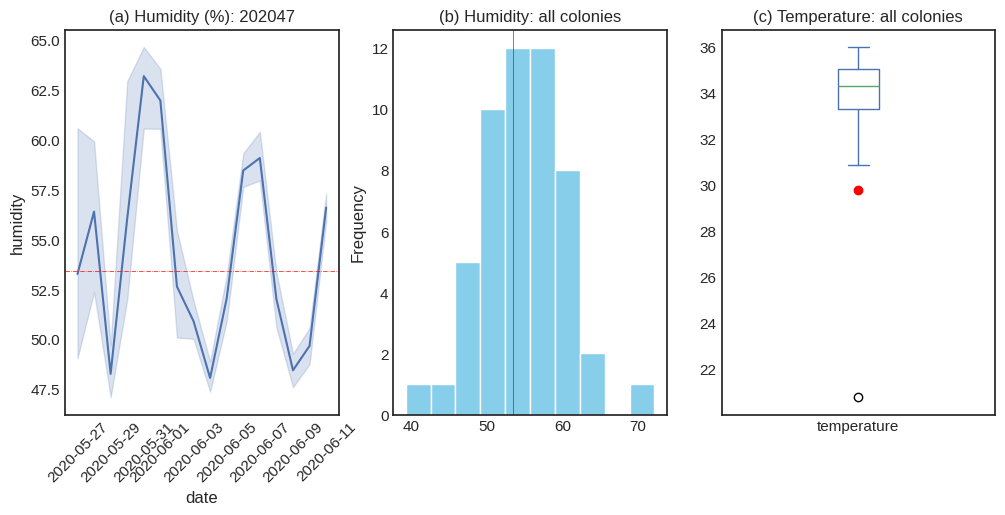

In [9]:
tmp = df[df.tag_number == 202047][['date','humidity','temperature']].set_index('date')

fig = plt.figure(figsize = (12,5))
ax0 = fig.add_subplot(1,3,1)
g = sns.lineplot(tmp['humidity'])
g.set_xticklabels(g.get_xticklabels(), rotation = 45); # suppresses text
plt.axhline( y= tmp.humidity.mean(), color = 'red', linewidth = 0.5, linestyle = '-.');
ax0.set_title('(a) Humidity (%): 202047')
#ax0.set_xlabel('Humidty (%)')
ax1 = fig.add_subplot(1,3,2)
df[df.month == 5].groupby(['tag_number'])['humidity'].mean().plot(kind='hist', color = 'skyblue');
ax1.set_title('(b) Humidity: all colonies');
plt.axvline(x = tmp.humidity.mean(), color = 'red', linewidth =0.5)
ax2 = fig.add_subplot(1,3,3)
df[df.month == 5].groupby(['tag_number'])['temperature'].mean().plot(kind='box')
ax2.set_title('(c) Temperature: all colonies');
ax2.scatter(1, tmp.temperature.mean(), color = 'red');

### Daily Averages

The graphical illustrations of data distributions (**Figures 2 - 4**) suggest that while there were no group differences (survived vs. dead) for average daily temperature and humidity, the audio features were likely to exhibit group differences, and thus could yield insight into survival prediction. This finding is consistent with Zhu et al.'s observations.

In [10]:
# Merge tag numbers with loss and loss adjusted information. Main dataset has no labels.
status = colony_info.groupby('tag_number')['loss'].max().reset_index()
status_adjusted = colony_info.groupby('tag_number')['loss_adjusted'].max().reset_index()
status = status.merge(status_adjusted)

In [11]:
#cols = list(df_agg.columns[0:20]) + ['audio_density_ratio_mean','density_variation_mean']
df_plot = status.merge(df_agg)
df_plot = df_plot[df_plot.month <= 6]

**Figure 2. Density distributions of daily averages of selected features.** *loss* was 0 for colonies that survived, and 1 for those that were either dead by the end of the study or had queen issues during summer and were removed from the study.

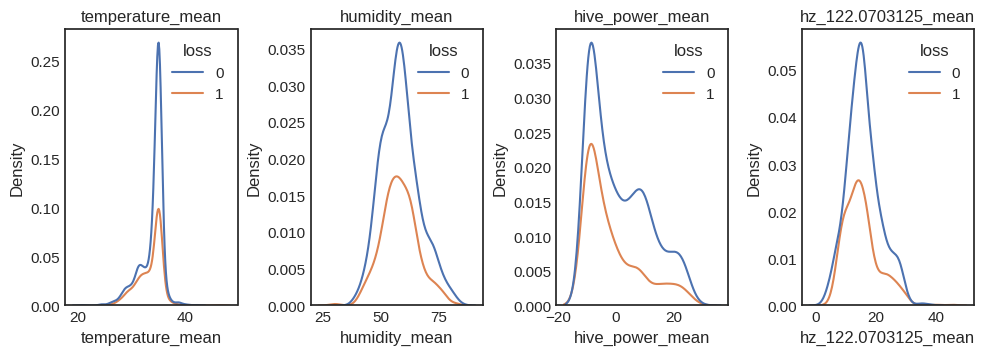

In [12]:
my_two_class_kdeplots(df_plot,select_cols(df_plot,'mean').columns[:4],'loss',6,4, 10, 20)

**Figure 3. Boxplots (five-number summaries) of daily averages of the same features as in Figure 2.**

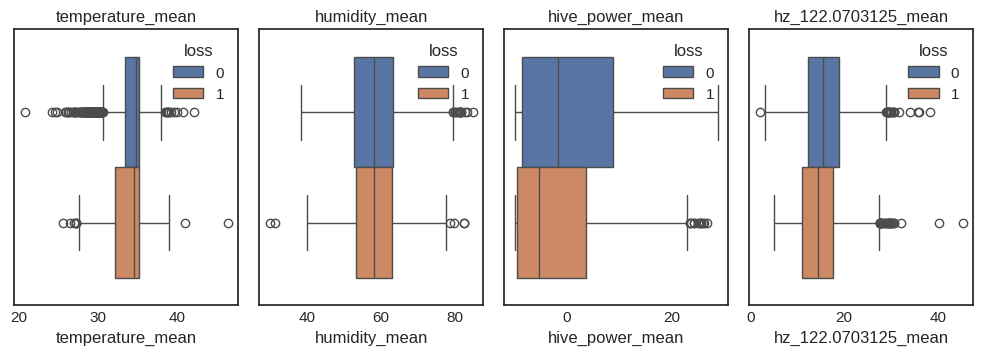

In [13]:
my_two_class_boxplots(df_plot,select_cols(df_plot,'mean').columns[:4],'loss',6,4, 10, 20)

**Figure 4: May and June distributions of daily hive power averages.**

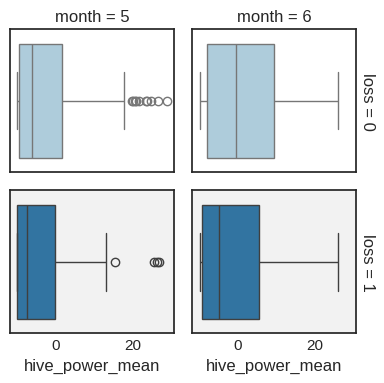

In [14]:
g = sns.FacetGrid(df_plot, col = "month", row = 'loss', hue = 'loss', 
                  margin_titles = True, despine = False, palette ='Paired', height = 2)
g.map_dataframe(sns.boxplot, x="hive_power_mean")
for (row_val, col_val), ax in g.axes_dict.items():
    if row_val == 1:
        ax.set_facecolor(".95")
    else:
        ax.set_facecolor((0, 0, 0, 0))

**Statistical differences.** 
Visualizations alone are generally not sufficient to determine if there is a statistically significant difference between groups. A Welch's t-test was performed to determine if the differences between the two colony groups were significant. As seen in Figures 2, 3, and 4, features exhibited skewed distributions, making a Welch's t-test suitable, since both the variances and group sizes were different. The test found that the means of the distributions of many of the daily averages of features were different between the two honey bee colony groups (**Table 5**). In the case of the average daily temperature, the t-test indicated that there was actually a difference between the groups. Such a finding was not unusual, as t-tests can detect subtle differences in skewed data, which may actually not be of relevance in practice.

---
**Table 5: Welch's t-test results.** The colonies that survived and those that did not were statistically different in 14 of the 22 features measured during May and June 2020.

---

In [15]:
features = select_cols(df_plot,'mean').columns
pvals = []
groups_different = []
for item in features:
    group1=df_plot[(df_plot.loss == 0)][item]
    group2=df_plot[(df_plot.loss == 1)][item]
    result = stats.ttest_ind(group1, group2, equal_var = False)
    pvals.append(np.round(result.pvalue,3))
    groups_different.append((result.pvalue < 0.05))
    #my_ttest(group1,group2, equal_var = False)
pd.DataFrame({'feature':features, 'p-values':pvals,'are groups different?':groups_different})

,feature,p-values,are groups different?
0,temperature_mean,0.001,True
1,humidity_mean,0.496,False
2,hive_power_mean,0.000,True
3,hz_122.0703125_mean,0.023,True
4,hz_152.587890625_mean,0.010,True
5,hz_183.10546875_mean,0.005,True
6,hz_213.623046875_mean,0.002,True
7,hz_244.140625_mean,0.005,True
8,hz_274.658203125_mean,0.011,True
9,hz_305.17578125_mean,0.032,True


# Models

## Model Selection

As discussed earlier in this report,  the goal of this project was to use a subset of Zhu et al's study data, namely the months of May and June in order to predict which colonies may experience issues later in the season or die during winters. The goal may seem overly ambitious; however, from a beekeeping perspective, early summer can make or break a colony. As with many other practical applications, it is better to prevent an issue from happening than deal with its consequences. It was reasonable to assume that colonies that experienced issue had some observations that were different from those of colonies that did not experience issues. Unsupervised algorithms that can flag anomalies and ouliers are suitable for such a task; **Isolation Forest** and **DBSCAN** were selected for this task. Note that even though the outcomes of the study were known, they were not made available to the two algorithms.

**Isolation Forest** is an unsupervised machine learning algorithm that identifies anomalies (outliers) in data. It does so by isolating them through random partitioning within a collection of binary decision trees. It performs well on high-dimensional data and is robust to noise, outliers, and multi-modal distributions, without requiring data normalization or  specific data distributions. Its drawbacks include poor performance on imbalanced datasets and sensitivity to hyperparameter; for example, choosing the optimal contamination rate (expected number of anomalies), when it is not known a priori, can be difficult. The process of flagging anomalous colonies was as follows: 
* For a given contamination rate, Isolation Forest labeled each observation in the data, with label -1 representing anomalies. The number of observations labeled with -1 was then determined for each colony, and divided by the total number of days the colony was observed during May - June 2020. A percentage of anomalous observation was computed and colonies were then ranked in terms of this percentage. Since, the contamination rate was unknown, different values were tested. A contamination rate of 0.05 (5%) produced the closest results to the ground truth.

**Density-based spatial clustering of applications with noise (DBSCAN)** is an unsupervised non-parametric clustering algorithm that groups together points that are closely packed, and labels as outliers points that lie alone in low-density regions. It is preferable for clustering and detecting outliers in low-to-moderate dimensional data with natural groupings, does not require knowledge of the number of cluster and has only two parameters. Some of its drawbacks include the choice of an optimal distance threshold (epsilon); if the data and scale are not well understood, choosing a meaningful distance threshold can be difficult. The process of flagging outliers was as follows:
* An optimal distance threshold parameter was identified using a k-distance graph approach. DBSCAN assigned each observation to a cluster or flagged it as an outlier (label -1). After that, the process was the same as for Isolation Forest. DBSCAN identified fewer problematic colonies, but mislabeled fewer surviving colonies than Isolation Forest.

## Detection with Isolation Forest

Isolation Forest flagged 9 of the problematic colonies. Interestingly, the most problematic colony was a winter/spring loss. Some of the colonies that survived were flagged as well, but **5 out of the 6 colonies that experienced queen issues in July and August were also identified.**

In [16]:
# subset May and June data
df_subset = df_agg[df_agg.date <= pd.to_datetime('2020-07-1', format = '%Y-%m-%d')]
df_subset = df_subset.drop(['date','beehub_name','month','day'], axis = 1)

# Merge tag numbers with loss and loss adjusted information
status = colony_info.groupby('tag_number')['loss'].max().reset_index()
status_adjusted = colony_info.groupby('tag_number')['loss_adjusted'].max().reset_index()
status = status.merge(status_adjusted)

tmp = df_subset.groupby('tag_number')['elapsed_days'].max().reset_index()
status = status.merge(tmp)

# Merge with phenotypic data
tmp = status.merge(phenotypic)
df_phenotypic = df_subset.merge(tmp[['tag_number','varroa_load','varroa_severity', 'hygienic_overall']],
                                how = 'left')

In [17]:
# Isolation Forest Parameters
n_estimators = 100 #100  # Number of trees
contamination = 0.05 #0.00875 #0.01  # Expected proportion of anomalies
sample_size = 256  # Number of samples used to train each tree
max_features = 1

iso_forest = IsolationForest(n_estimators = n_estimators, contamination = contamination, 
                            max_samples = sample_size, random_state = 42)

X = df_phenotypic.copy(deep = True)
# X = df_subset.copy(deep = True)

iso_forest.fit(X.drop(['tag_number'], axis = 1))
#print(iso_forest.get_params())

X['scores'] = iso_forest.decision_function(X.drop(['tag_number'], axis = 1))
X['anomaly'] = iso_forest.predict(X.drop(['scores','tag_number'], axis = 1))

#X.anomaly.value_counts().reset_index()

tmp = X.groupby(['tag_number'])['anomaly'].value_counts().reset_index()
tmp = tmp[tmp.anomaly == -1]

anomalies = status.merge(tmp)
anomalies['percent_observations'] = np.round(anomalies['count']/anomalies['elapsed_days']*100,0)
anomalies = (anomalies.sort_values(by = 'percent_observations', ascending = False)
             .drop(['elapsed_days','count','anomaly'], axis = 1))

## Detection with DBSCAN

The distance parameter `epsilon` was determined using a k-distance graph approach: for each point, the distance to the k-th nearest neighbor was calculated and plotted in ascending order. The epsilon value corresponding to the elbow point (where the curvature of the graph has the largest change) was the optimal value for this dataset.

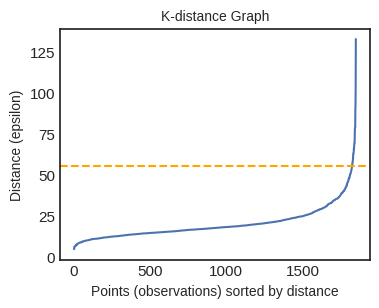

In [18]:
nn = NearestNeighbors(n_neighbors = 10) # corresponds to min_samples in DBSCAN
nbrs = nn.fit(df_phenotypic.drop('tag_number', axis = 1))
distances, indices = nbrs.kneighbors(df_phenotypic.drop('tag_number', axis =1))
distances = np.sort(distances, axis = 0)
distances = distances[:,1]

plt.figure(figsize=(4,3))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=10)
plt.xlabel('Points (observations) sorted by distance',fontsize=10)
plt.ylabel('Distance (epsilon)',fontsize=10)
plt.axhline(y = 55, color = 'orange', linestyle = '--')
plt.show()

In [19]:
clustering = DBSCAN(eps=55, min_samples = 2).fit(df_phenotypic.drop('tag_number', axis = 1))

labels_df = pd.DataFrame(clustering.labels_)
#print(labels_df.value_counts())
labels_df = labels_df.merge(df_phenotypic['tag_number'], right_index=True, left_index=True)
labels_df = labels_df.rename(columns={0:'cluster'})

tmp = labels_df.groupby('tag_number')['cluster'].value_counts().reset_index()
tmp = tmp[tmp['cluster'] == -1]
outliers = tmp.merge(status) 
outliers['percent_observations'] = np.round(outliers['count']/outliers['elapsed_days']*100,0)
outliers = (outliers.sort_values(by ='percent_observations', ascending = False)
            .drop(['cluster','count','elapsed_days'], axis = 1))

---
**Table 6. Isolation Forest and DBSCAN combined results.** The two methods together flagged 14 of the 18 (78%) failed colonies, and **all but one** of the colonies with summer queen issues. 

---

In [20]:
outliers = outliers.rename(columns={'percent_observations':'percent_observations_DBSCAN'})
anomalies = anomalies.rename(columns={'percent_observations':'percent_observations_IsoForest'})

tmp = anomalies.merge(outliers, how = 'outer').sort_values(by = 'loss_adjusted',ascending = False)
tmp = tmp[tmp.loss == 1]
tmp = (tmp.merge(colony_info[['tag_number','mortality_cause']], how='left'))
   # .sort_values('percent_observations_IsoForest', ascending= False))
tmp

,tag_number,loss,loss_adjusted,percent_observations_IsoForest,percent_observations_DBSCAN,mortality_cause
0,202061,1,2,9.0,3.0,Queen failure
1,202128,1,2,3.0,NaN,Queen failure
2,202065,1,2,19.0,6.0,Starved
3,202214,1,2,6.0,3.0,Dead queen
4,202046,1,2,8.0,NaN,Queenless
5,202048,1,2,20.0,11.0,Queen failure
6,202050,1,2,NaN,3.0,Dead queen
7,202063,1,2,3.0,3.0,"Fall loss, reason unknown"
8,202072,1,2,2.0,2.0,Queen failure
9,202209,1,1,6.0,6.0,"Queenless, wont be overwintered"


---
**Table 7. Surviving colonies identified as outliers by the two methods.** Isolation Forest and DBSCAN together mislabeled a total of 23 of the surviving colonies, but they agreed on only 7 of these colonies. Setting a threshold for *percent_observations* to greater or equal to the contamination rate used for Isolation Forest would reduce the former number to 13 and the latter to 5. However it is debatable whether this method should be used, since DBSCAN does not require a contamination rate to determine outliers. Also, note that DBSCAN identified less survivors as outliers. Nevertheless, this finding suggest that the two methods together can help both identify problems and rule out false positives. It appears that on this dataset, Isolation Forest was better at ruling in true positives (actual failed colonies), while DBSCAN was better at ruling out false positives (surviving colonies labeled as outliers).

---

In [21]:
tmp = anomalies.merge(outliers, how = 'outer').sort_values(by = 'loss_adjusted',ascending = False)
tmp = tmp[tmp.loss == 0]
tmp = (tmp.merge(colony_info[['tag_number','mortality_cause']], how='left'))
tmp

,tag_number,loss,loss_adjusted,percent_observations_IsoForest,percent_observations_DBSCAN,mortality_cause
0,202196,0,0,3.0,NaN,NaN
1,202131,0,0,8.0,3.0,NaN
2,202132,0,0,11.0,NaN,NaN
3,202039,0,0,17.0,NaN,NaN
4,202203,0,0,3.0,NaN,NaN
5,202211,0,0,8.0,NaN,NaN
6,202215,0,0,3.0,6.0,NaN
7,202130,0,0,8.0,NaN,NaN
8,202074,0,0,9.0,NaN,NaN
9,202123,0,0,3.0,NaN,NaN


# Conclusions

With just 35 - 36 days of humidity, temperature, and audio measurements combined with phenotypic measurements available on a few occasions, two unsupervised models suited for anomaly detection were able to pinpoint 5 of the 6 colonies that would later experience queen issues, and 9 of the 12 colonies that would die sometime between November and April of the following year. Thus, a total of 14 of the 18 (78%) colonies that were losses were identified early. This finding has tremendous importance for colony management, and highlights the utility of an automated beehive monitoring system. For example, continuous data recording along with a  method of frequent data analysis, would have undoubtedly saved the colony that developed chalkbrood.

Zhu et al used an Isolation Forest model to detect anomalies in the winter data and were able to clearly distinguish only 4 failed hives of the 10 winter losses (Figure 10c in Reference 1).  The method presented here was able to identify colonies that would fail in summer as well as soem of those that failed in winter.

The models also flagged colonies that survived, although they only agreed on 5 of those colonies. In general, when the outcomes (data labels) are not known (and in a real-time monitoring situation they are not), using multiple unsupervised models is highly beneficial, as can be seen here. 

The method described in this report could be improved, as follows:
* Improve the data, by including more frequent Varroa mite counts, and using a mathematical model for Varroa reproduction to estimate Varroa counts for each day. Several such models have been developed.
* Investigate whether adding more granularity to the data, such as averaging over shorter periods of time than 24 hours, could improve the results.
* The age of each colony is relevant. Were the colonies started from a nucleus, a package, or were they overwintered from the prior season 2019?
* Monitoring cluster size dynamics in winter using thermal imaging could add interesting insights.
* Monitoring honey consumption during winter could also add insight into the colony dynamics. Remote monitoring of beehive weight is a critical practice in modern beekeeping; it enables beekeepers to track colony health, honey production, and food reserves without physically inspecting the hives. This is achieved through electronic beehive scales such as Broodminder and HiveGenie. This is especially important when overwintering is done in a climate-controlled environment, where the warmer temperature may prompt the bees to be more active and consume more food. Recall one colony was lost to starvation and that should have not happened in this context.
* To better predict winter losses, honey information and syrup uptake would have to be included in the data.
* Brood information has not been included, as it was not available for all colonies, and was sparse for those colonies where it was available. A model estimating the colony growth could be used to estimate a daily average of brood cells. 
* The results were improved by including features engineered from the phenotypic data (analysis not shown for the sake of readability). Other ways of characterizing phenotypic data, such as assigning a colony score based on Varroa counts, hygienic, and defensive behvaior could further improve the results. 
* The true anomaly rate is not known. It would be interesting to design a method to characterize anomalous observations in the context of honey bee data. The method may reveal unknown factors and help improve beekeeping practices as well.

# References
1. Zhu, Y., Abdollahi, M., Maucourt, S. et al. MSPB: a longitudinal multi-sensor dataset with phenotypic trait measurements from honey bees. Sci Data 11, 860 (2024). https://doi.org/10.1038/s41597-024-03695-1
2. Project webpage: https://zhu00121.github.io/MSPB-webpage/
3. https://www.betterbee.com/glossary/
4. Morgane Nouvian, Judith Reinhard, Martin Giurfa; The defensive response of the honeybee Apis mellifera. J Exp Biol 15 November 2016; 219 (22): 3505–3517. doi: https://doi.org/10.1242/jeb.143016
5. Zarate D, Mukogawa B, Kohn J, Nieh JC. Seasonal variation in defense behavior in European and scutellata-hybrid honey bees (Apis mellifera) in Southern California. Sci Rep. 2023 Aug 7;13(1):12790. doi: 10.1038/s41598-023-38153-2. PMID: 37550348; PMCID: PMC10406949.
6. Guzman-Novoa, E., Hunt, G. J. Page, R. E., Jr., Uribe-Rubio, J. L., Prieto-Merlos, D., Becerra-Guzman, F., Paternal Effects on the Defensive Behavior of Honeybees, Journal of Heredity, 2005, 96:4, pp. 376-380, https://doi.org/10.1093/jhered/esi038
7. Akongte PN, Park BS, Kim DW, Choi YS. Honey Bee Colonies (Apis mellifera L.) Perform Orientation Defensiveness That Varies among Bred Lines. Insects. 2023 Jun 12;14(6):546. doi: 10.3390/insects14060546. PMID: 37367362; PMCID: PMC10298944.
8. Seeley TD, Honeybee Democracy, Princeton University Press, 2010, ISBN 9780691147215
9. Storch H, At the Hive Entrance, CreateSpace Independent Publishing Platform, 2014, ISBN 10: 1502864703 / ISBN 13: 9781502864703
10. Gould JL. Honey bee cognition. Cognition. 1990 Nov;37(1-2):83-103. doi: 10.1016/0010-0277(90)90019-g. PMID: 2269009.
11. Pahl, M., Tautz, J., Zhang, S. (2010). Honeybee cognition. In: Kappeler, P. (eds) Animal Behaviour: Evolution and Mechanisms. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-02624-9_4
12. Mutinelli, F. (2021). Euthanasia and welfare of managed honey bee colonies. Journal of Apicultural Research, 62(1), 2–10. https://doi.org/10.1080/00218839.2021.1895569
13. https://www.scientificamerican.com/article/do-insects-feel-joy-and-pain/
14. https://www.science.org/content/article/bees-may-feel-pain
15.  M. Gibbons, E. Versace, A. Crump, B. Baran, & L. Chittka, Motivational trade-offs and modulation of nociception in bumblebees, Proc. Natl. Acad. Sci. U.S.A. 119 (31) e2205821119, https://doi.org/10.1073/pnas.2205821119 (2022)
16.  https://www.beepods.com/inspect-for-chalkbrood-infections/
17.  https://backyardbeekeeping.iamcountryside.com/health-pests/chalkbrood-disease-in-honey-bees/
18.  https://www.sussex.ac.uk/lasi/sussexplan/hygienicbees
19.  Gianluigi Bigio, Roger Schürch, Francis L. W. Ratnieks, Hygienic Behavior in Honey Bees (Hymenoptera: Apidae): Effects of Brood, Food, and Time of the Year, Journal of Economic Entomology, vol. 106:6, 2013, pp. 2280–2285, https://doi.org/10.1603/EC13076
20.  Lu, Haowen. (2025). Evaluating the Performance of SVM, Isolation Forest, and DBSCAN for Anomaly Detection. ITM Web of Conferences. 70. 10.1051/itmconf/20257004012
21.  D Wilkinson, G.C Smith, A model of the mite parasite, Varroa destructor, on honeybees (Apis mellifera) to investigate parameters important to mite population growth, Ecological Modelling, Volume 148, Issue 3, 2002, Pages 263-275, ISSN 0304-3800, https://doi.org/10.1016/S0304-3800(01)00440-9. (https://www.sciencedirect.com/science/article/pii/S0304380001004409)
22.  Degrandi-Hoffman, Gloria & Curry, Robert. (2004). A mathematical model of Varroa mite (Varroa destructor Anderson and Trueman) and honeybee (Apis mellifera L.) population dynamics. International Journal of Acarology. 30. 259-274. 10.1080/01647950408684393.
23.  Cecchi S, Spinsante S, Terenzi A, Orcioni S. A Smart Sensor-Based Measurement System for Advanced Bee Hive Monitoring. Sensors (Basel). 2020 May 10;20(9):2726. doi: 10.3390/s20092726. PMID: 32397686; PMCID: PMC7248914.
24.   Liu, F. T., K. M. Ting, and Z. Zhou. "Isolation Forest," 2008 Eighth IEEE International Conference on Data Mining. Pisa, Italy, 2008, pp. 413-422.